# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.multioutput import RegressorChain
from sklearn.neural_network import MLPRegressor

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/test.csv')
train_rows = df.shape[0]

df

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8


# Feature Engineering

In [3]:
import datetime as dt
from scipy import stats
from scipy.special import boxcox, inv_boxcox

# Normalising Data

target_carbon_monoxide, lambdaval_co = stats.boxcox(df['target_carbon_monoxide'])
target_benzene, lambdaval_ben = stats.boxcox(df['target_benzene'])
target_nitrogen_oxides, lambdaval_no = stats.boxcox(df['target_nitrogen_oxides'])

df['target_carbon_monoxide'] = target_carbon_monoxide
df['target_benzene'] = target_benzene
df['target_nitrogen_oxides'] = target_nitrogen_oxides

# for inverse boxcox
# inv_boxcox(z, lambdaval)

# combining the test and train dataset
df = df.append(test)

df['date_time'] = pd.to_datetime(df['date_time'])
df['dayoftheweek'] = df['date_time'].dt.dayofweek #Weekly Seasonality
df['hourofday'] = df['date_time'].dt.hour #Daily Seasonality
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
# df['time'] = df['date_time'].dt.astype(np.int64) #Yearly Trend

In [5]:
df

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,dayoftheweek,hourofday,month,day
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2,18,3,10
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2,19,3,10
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2,20,3,10
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2,21,3,10
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,2,22,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...
2242,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,0,10,4,4
2243,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,0,11,4,4
2244,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,0,12,4,4
2245,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,0,13,4,4


In [6]:
df.isnull().sum()

deg_C                0
relative_humidity    0
absolute_humidity    0
sensor_1             0
sensor_2             0
sensor_3             0
sensor_4             0
sensor_5             0
dayoftheweek         0
hourofday            0
month                0
day                  0
dtype: int64

<AxesSubplot:>

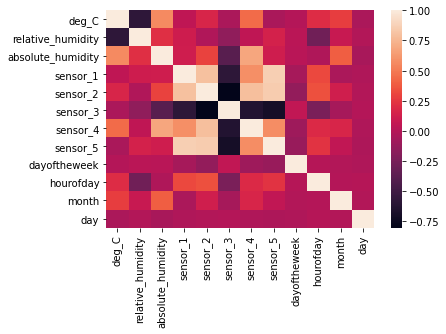

In [8]:
sns.heatmap(df.corr())

<AxesSubplot:>

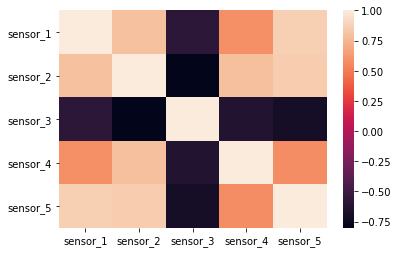

In [65]:
sns.heatmap(df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']].corr())

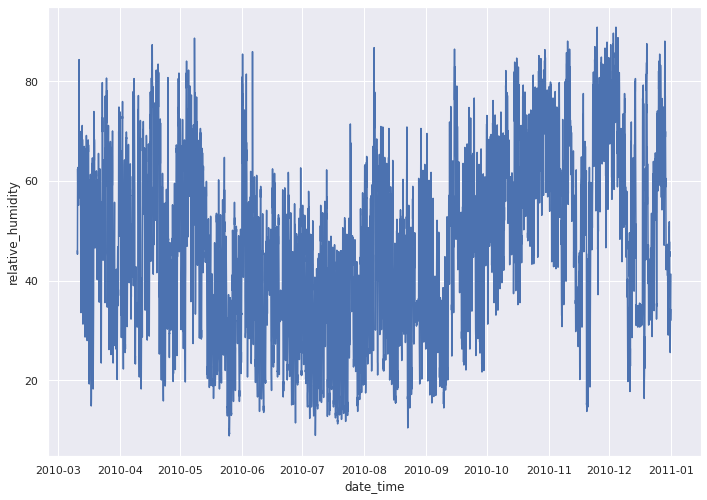

In [70]:
df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
sns.lineplot(x=df['date_time'], y=df['relative_humidity'])
sns.set(rc={'figure.figsize':(11.7,12)})

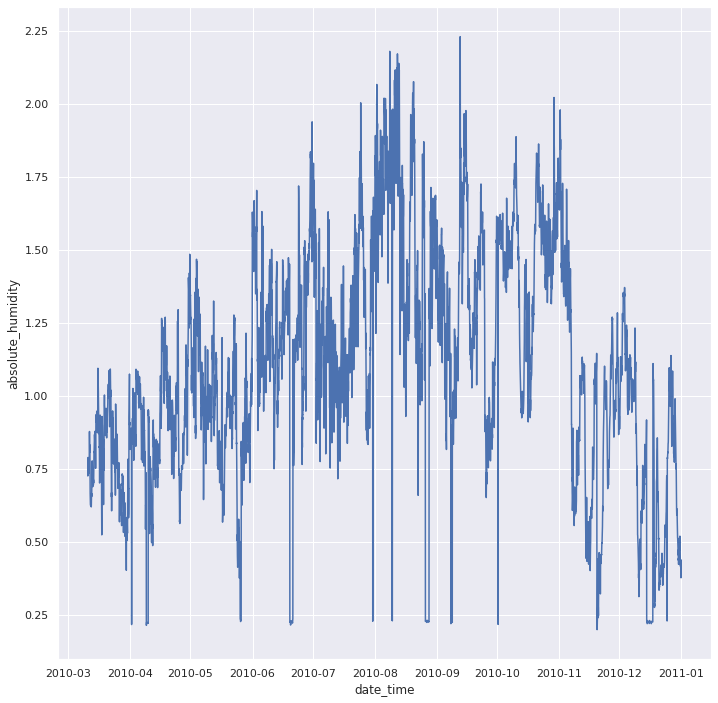

In [71]:
sns.lineplot(x=df['date_time'], y=df['absolute_humidity'])
sns.set(rc={'figure.figsize':(11.7,12)})

In [ ]:
y = df[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]
df.drop(['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides', 'date_time'], axis = 1, inplace = True)

# Modelling

In [9]:
# scaler = MinMaxScaler()
scaler = RobustScaler()
X_tr = scaler.fit_transform(df)

X = X_tr[:train_rows]
y = y[:train_rows]
X_test = X_tr[train_rows:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6399, 12), (6399, 3), (712, 12), (712, 3))

In [25]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

estimators = [('lr', RidgeCV()), ('svr', LinearSVR(random_state=42)), ('mlp', MLPRegressor(random_state=1, max_iter = 500))]
reg = StackingRegressor(estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=10,
                                           random_state=42))

In [36]:
model11 = RegressorChain(MLPRegressor(random_state=1, max_iter = 500)).fit(X_train, y_train)
model12 = RegressorChain(XGBRegressor()).fit(X_train, y_train)
model13 = RegressorChain(LGBMRegressor(random_state=1)).fit(X_train, y_train)
model14 = RegressorChain(RandomForestRegressor(random_state=3)).fit(X_train, y_train)

model21 = MultiOutputRegressor(MLPRegressor()).fit(X_train, y_train)
model22 = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)
model23 = MultiOutputRegressor(LGBMRegressor(random_state=1)).fit(X_train, y_train)
model24 = MultiOutputRegressor(RandomForestRegressor(random_state=3)).fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [59]:
models = [model11, model12, model13, model14, model21, model22, model23, model24]

scores = []
train_scores = []
msle_scores = []

for model in models:
    scores.append(model.score(X_val, y_val))
    train_scores.append(model.score(X_train, y_train))
    msle_scores.append(mean_squared_log_error(np.absolute(y_val), np.absolute(model.predict(X_val)), multioutput='raw_values'))

# Analysing R2 scores

<AxesSubplot:>

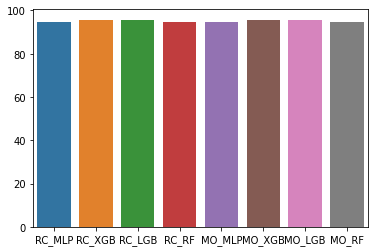

In [57]:
sns.barplot(x=['RC_MLP', 'RC_XGB', 'RC_LGB', 'RC_RF', 'MO_MLP', 'MO_XGB', 'MO_LGB', 'MO_RF'], y=np.array(scores)*100)

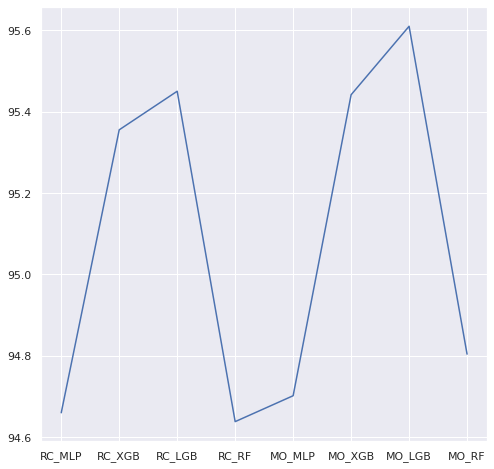

In [80]:
sns.lineplot(x=['RC_MLP', 'RC_XGB', 'RC_LGB', 'RC_RF', 'MO_MLP', 'MO_XGB', 'MO_LGB', 'MO_RF'], y=np.array(scores)*100)
sns.set(rc={'figure.figsize':(8,8)})

<AxesSubplot:>

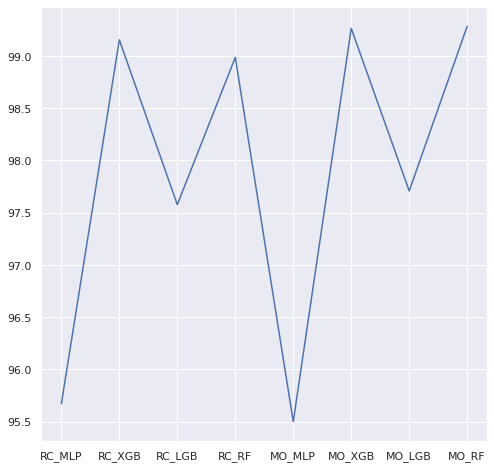

In [82]:
sns.lineplot(x=['RC_MLP', 'RC_XGB', 'RC_LGB', 'RC_RF', 'MO_MLP', 'MO_XGB', 'MO_LGB', 'MO_RF'], y=np.array(train_scores)*100)

In [72]:
print("Mean score of RegressorChain : ",np.array(scores[:4]).mean())
print("Mean score of MultiOutputRegressor : ", np.array(scores[4:]).mean())

Mean score of RegressorChain :  0.9502593422907512
Mean score of MultiOutputRegressor :  0.9513938925285702


In [73]:
print("Mean train score of RegressorChain : ", np.array(train_scores[:4]).mean())
print("Mean train score of MultiOutputRegressor : ", np.array(train_scores[4:]).mean())

Mean score of RegressorChain :  0.9784625229222562
Mean score of MultiOutputRegressor :  0.9793814696680931
